# **Tutorial 4** - Geophysics (Seismology)

In this tutorial we will learn how to

 1. Prepare **gridded data**: [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grd2xyz.html)
 2. Create a **contour map**: [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html)
 3. Create a **profile plot**: [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) and [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html)

-----
This tutorial is part of the AGU2024 annual meeting GMT/PyGMT pre-conference workshop (PREWS9) **Mastering Geospatial Visualizations with GMT/PyGMT**
- Conference: https://agu.confex.com/agu/agu24/meetingapp.cgi/Session/226736
- GitHub: https://github.com/GenericMappingTools/agu24workshop
- Website: https://www.generic-mapping-tools.org/agu24workshop
- Recommended version: PyGMT v0.13.0 with GMT 6.5.0

## 0. General stuff

Import the required packages. Besides [`PyGMT`](https://www.pygmt.org/v0.13.0) we also use [`NumPy`](https://numpy.org/doc/stable/).

In [1]:
import pygmt
import numpy as np

## 1. Prepare gridded data: [`pygmt.xyz2grd`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grd2xyz.html)


## 2. Create a contour map: [`pygmt.Figure.grdcontour`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.Figure.grdcontour.html)
Convert grids or images to contours and plot them on maps

you need to define:
1. `grid`: Accessing the remote datasets or providing your dataset as ``xarray.DataArray``
2. `level`: Specify the contour intervals to generate; for example, value of 1000 means plotting contour lines at every 1000 m.
3. `annotation`: Annotated contour levels
4. `limit`: Draw contours below low or above high, e.g, [-4000, 0] means drawing contour lines below sea level and above -4000 m.

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


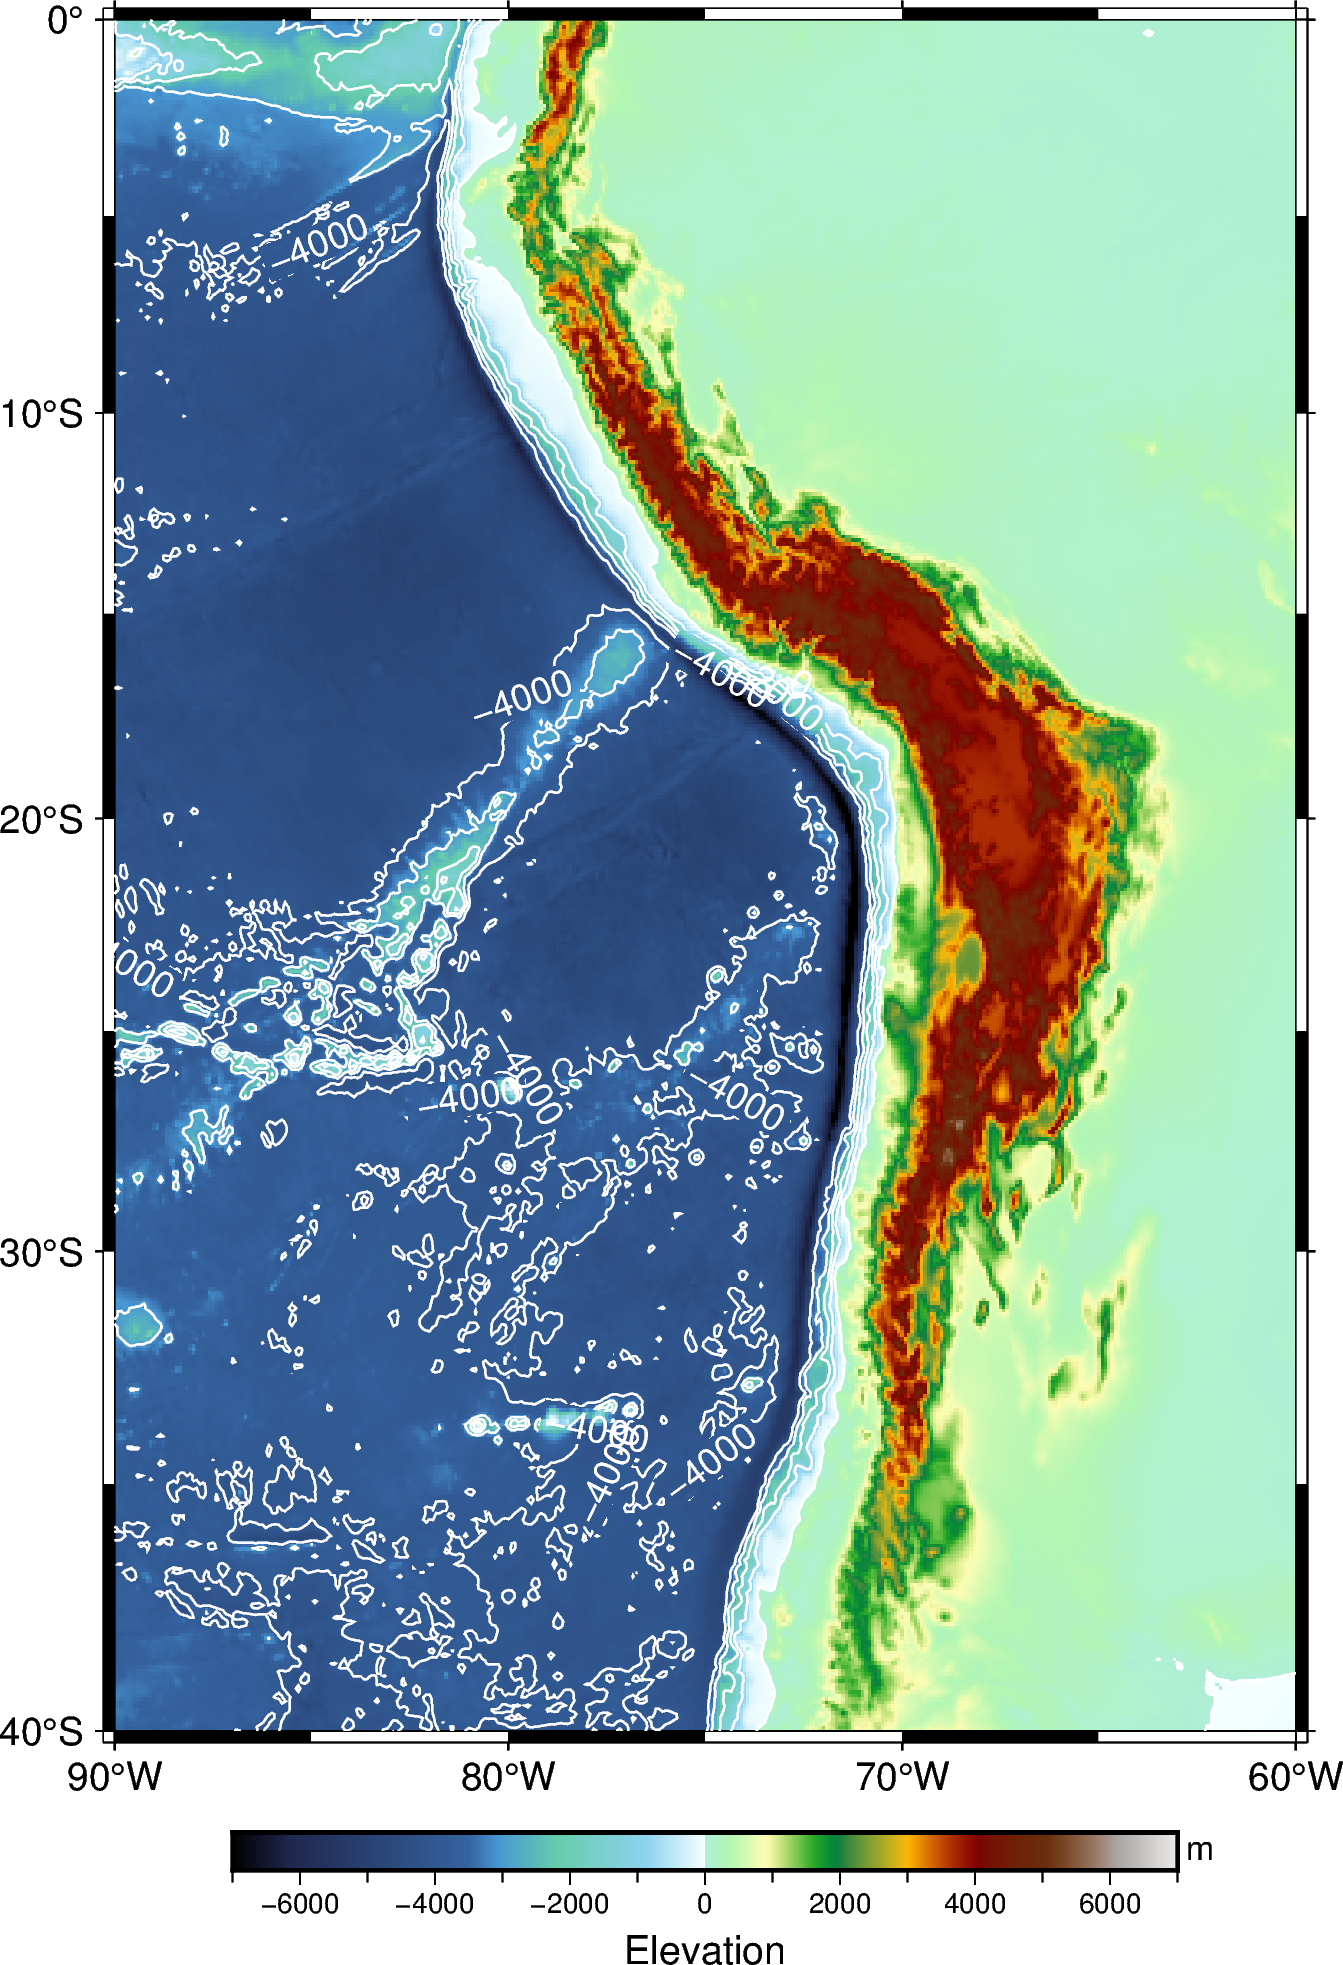

In [2]:
fig = pygmt.Figure()

grid = pygmt.datasets.load_earth_relief(resolution="05m", region=[-90, -60, -40, 0])
cpt = pygmt.makecpt(cmap='earth', series=[-7000, 7000], continuous=True)

fig.grdimage(grid=grid, cmap=cpt, projection="M10c", frame=['a10f5'])

fig.grdcontour(grid=grid, annotation=2000, levels=1000, limit=[-4000, 0], pen='0.5p,white')

fig.colorbar(frame=["x+lElevation", "y+lm", 'a2000f1000'])
fig.show()

## 3. Create a profile plot: [`pygmt.project`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.project.html) and [`pygmt.grdtrack`](https://www.pygmt.org/v0.13.0/api/generated/pygmt.grdtrack.html)

`pygmt.project` is designed to sample points along a great circle, a straight line, or across specified distance. 
In our case, we will create a profile by point-to-point, you need to define
1. `center` and `endpoint`: specify the start and end coordinates of the profile
2. `generate`: distance interval of each point. e.g., `10` means points are generated every 10 degrees along the profile. 
3. `unit` (option): By default, `unit=False`, the distances of points along the profile are measured in degrees. When `unit=True` is used, it specifies that the distances are generated in kilometers. 

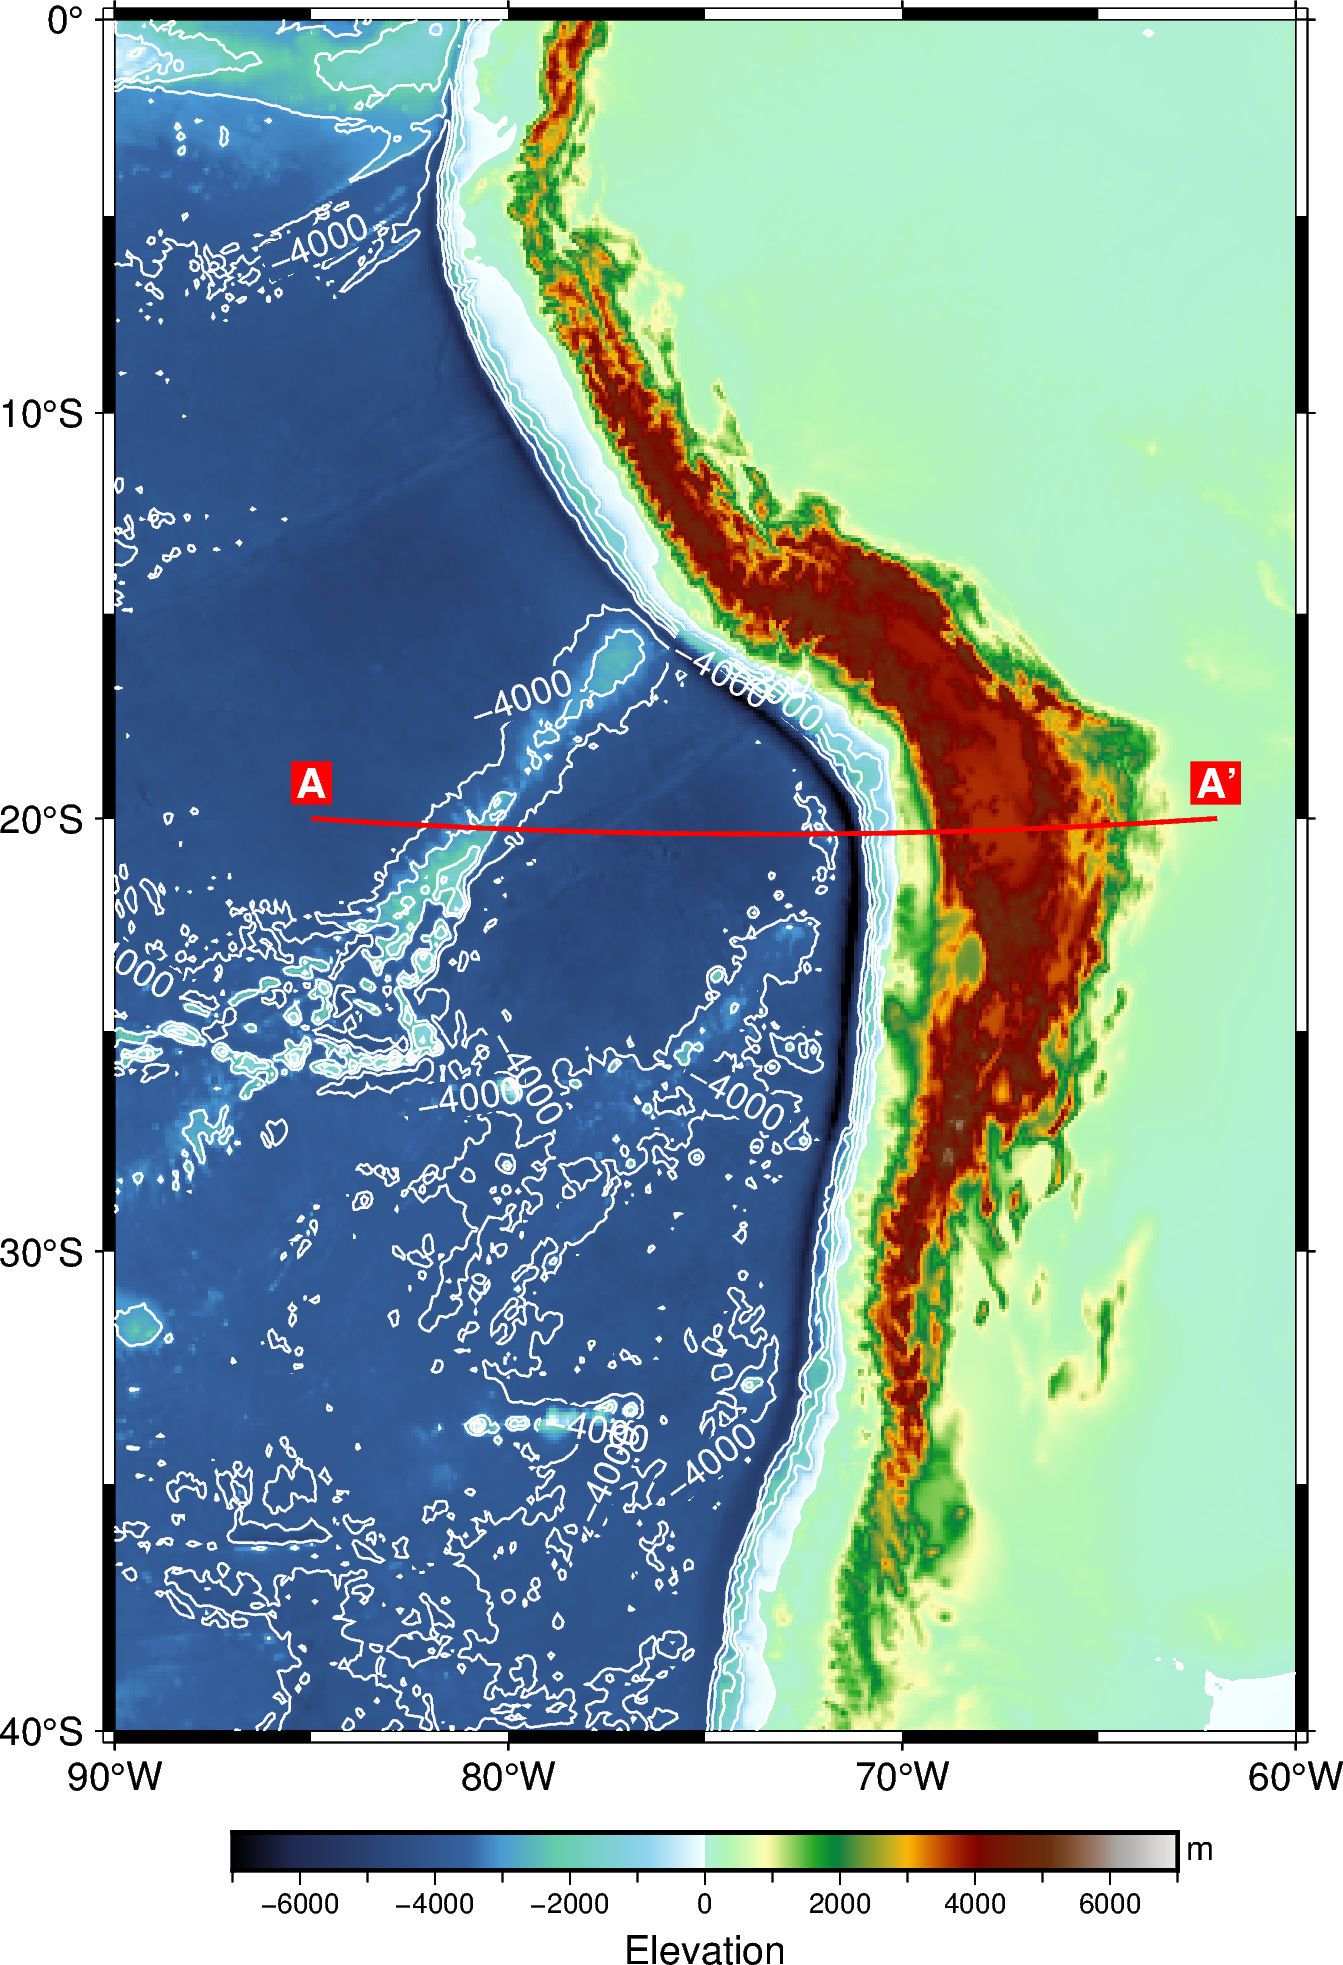

In [3]:
# Choose a survey line
start_x = -85 # Longitude in degrees East
start_y = -20 # Latitude in degrees North
end_x = -62
end_y= -20

# Plotting to make sure the profile you want
fig.plot(
    x=[start_x, end_x],  
    y=[start_y, end_y],  
    pen="1p,red",
)

fig.text(
    x=[start_x, end_x], 
    y=[start_y, end_y],
    text=["A", "A'"],
    offset="0c/0.3c", 
    font="10p,1,white",
    fill="red",
)

track_df = pygmt.project(
    center=f"{start_x}/{start_y}", 
    endpoint=f"{end_x}/{end_y}", 
    # Output data in steps of 1 km with setting unit=True
    generate="1", 
    unit=True,
)

fig.show()

In [4]:
track_df.head()

,r,s,p
0,-85.000000,-20.000000,0.0
1,-84.990453,-20.000624,1.0
2,-84.980905,-20.001248,2.0
3,-84.971358,-20.001871,3.0
4,-84.961810,-20.002493,4.0


**NOTE**: the output format is `pandas.DataFrame`, and **r** and **s** together provide the geographic coordinates (longitude, latitude) of each point along the track, while **p** gives the cumulative distance along the profile up to each point. 


Then, we use `pygmt.grdtrack` to sample topographic (or other grid-based data) values along a profile that you generated using `pygmt.project`. This allows you to retrieve data from a grid file along a specified path. 

Therefore, you need to provide

1. `grid`: Specifies the grid file (e.g., a topographic grid) from which data will be sampled
2. `point`: Provides the coordinates of the profile points
3. `newcolname`: Name for the new column with sampled values

In [5]:
# Extract the elevation at the generated points from the downloaded grid
# and add it as new column "elevation" to the pandas.DataFrame
track_df = pygmt.grdtrack(
    grid=grid,
    points=track_df,
    newcolname="elevation",
)

In [6]:
track_df.head()

,r,s,p,elevation
0,-85.000000,-20.000000,0.0,-4440.500000
1,-84.990453,-20.000624,1.0,-4445.130540
2,-84.980905,-20.001248,2.0,-4450.944209
3,-84.971358,-20.001871,3.0,-4457.558040
4,-84.961810,-20.002493,4.0,-4464.581447


**Note**: the new column is **elevation** to indicate the elevation variation along the track

## need to add

In [7]:
print(min(track_df["elevation"]), max(track_df["elevation"]))

-7319.553238186641 4422.575285314314


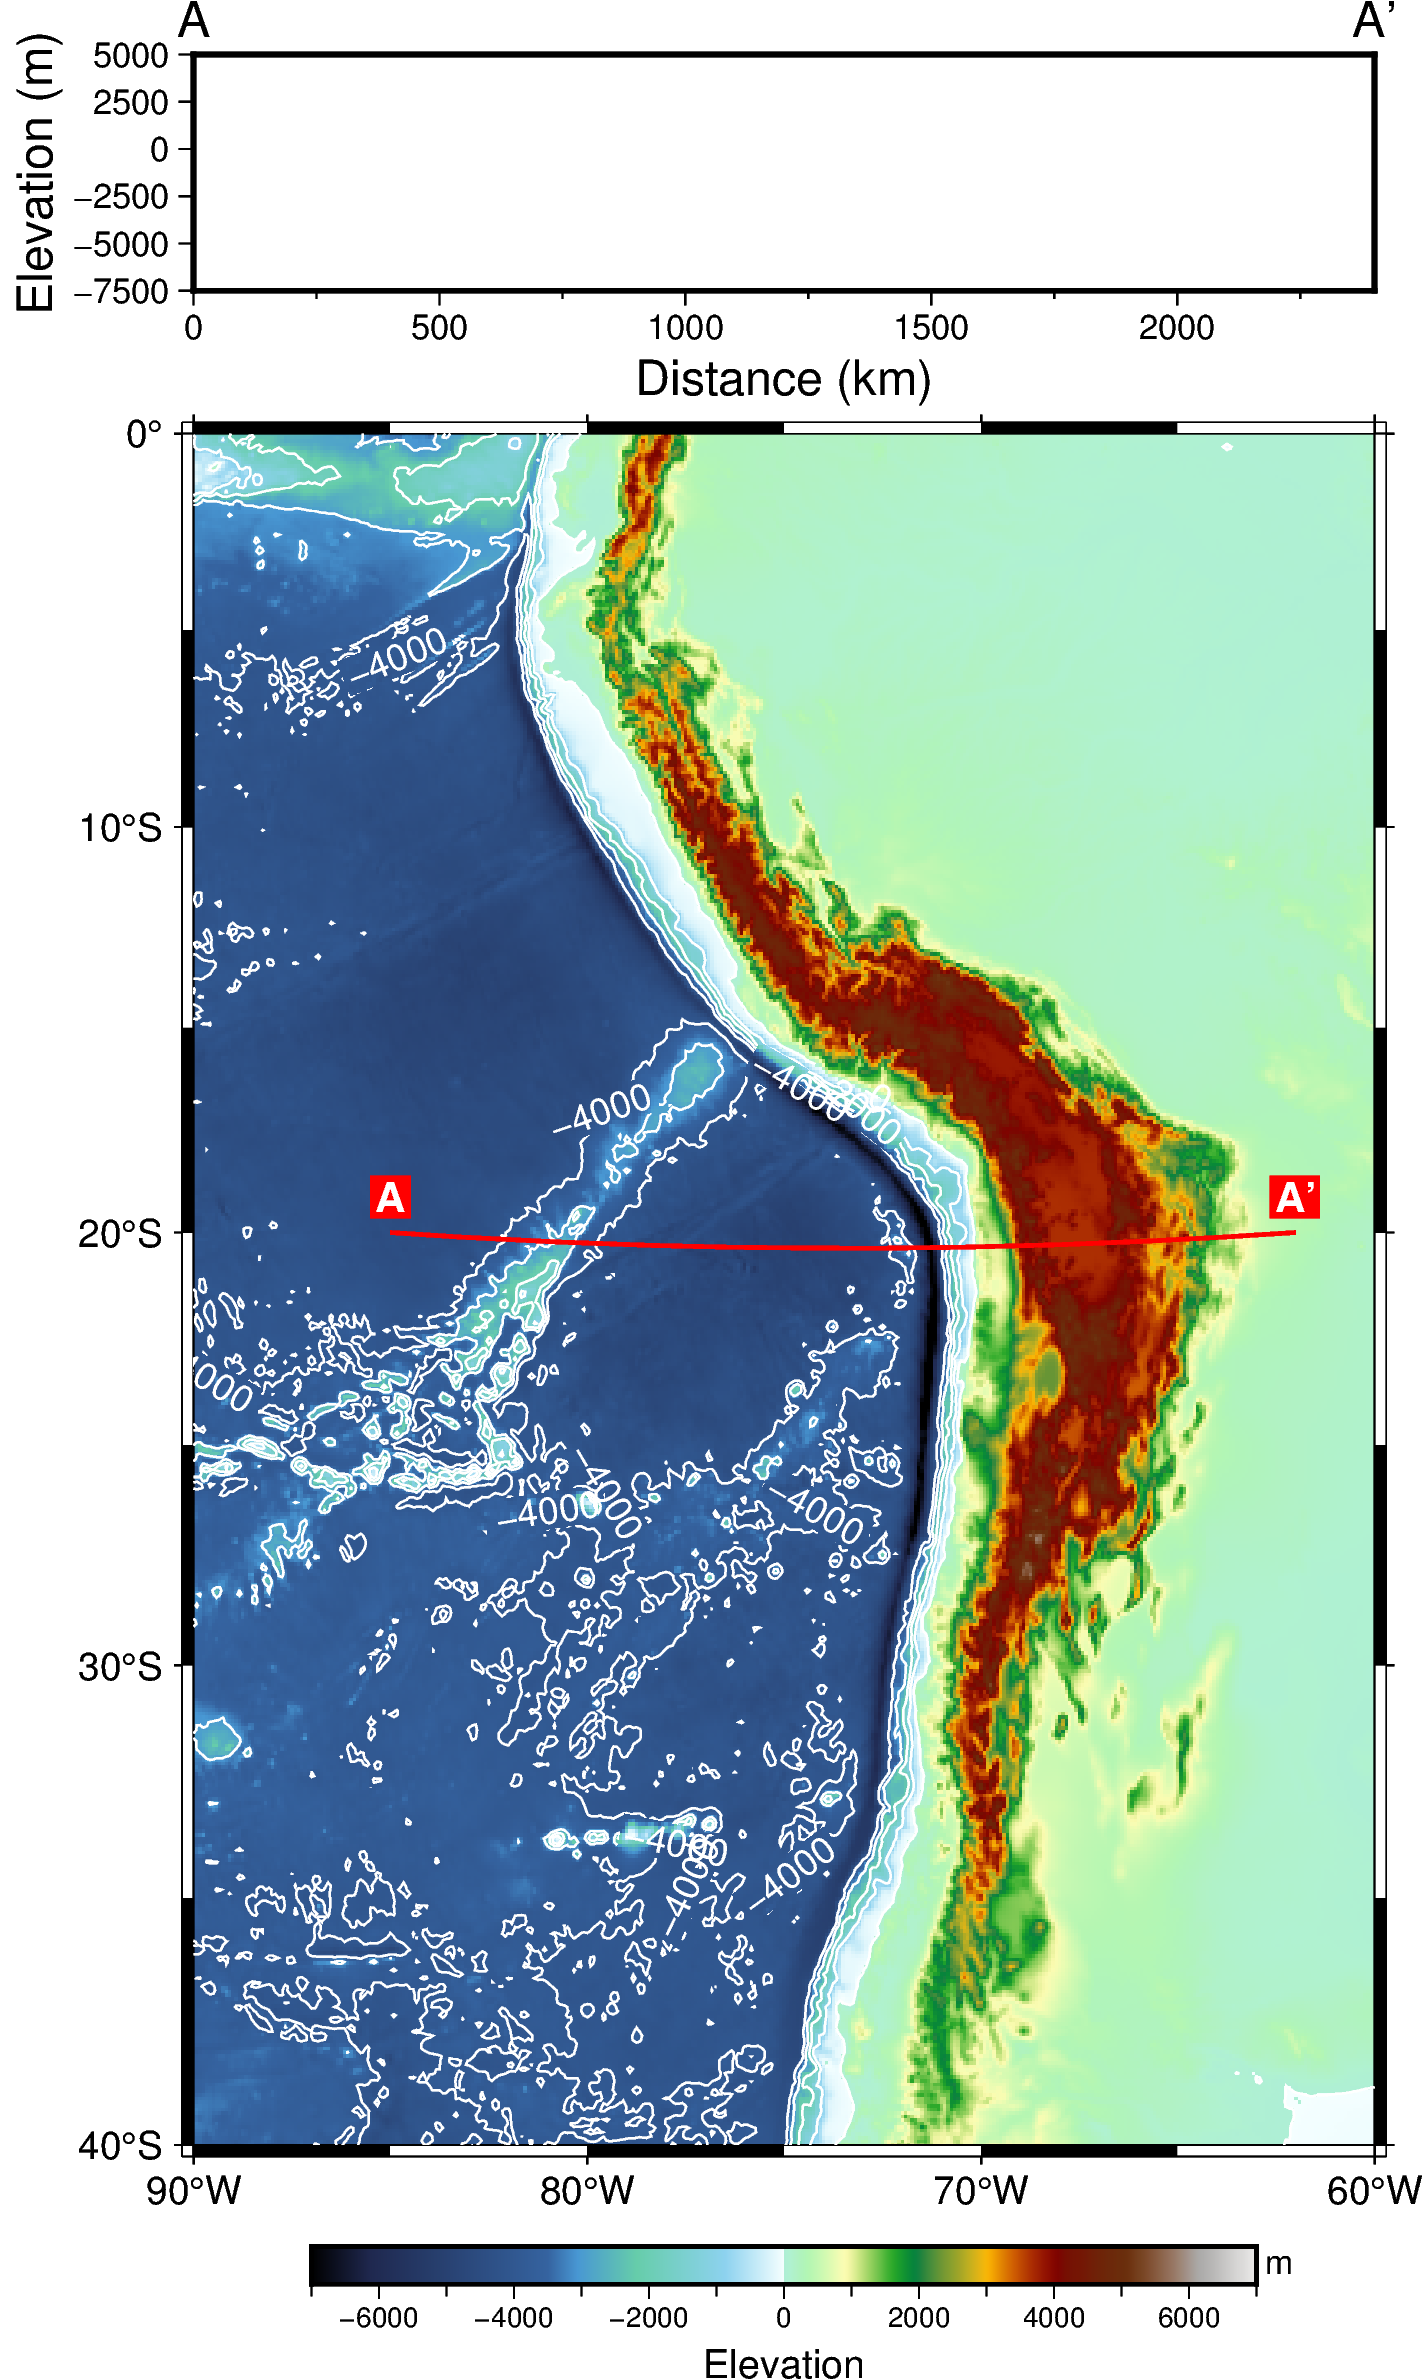

In [8]:
fig.shift_origin(yshift="15.7c")

fig.basemap(
    region=[0, max(track_df.p), -7500, 5000],  # x_min, x_max, y_min, y_max
    # Cartesian projection with a width of 12 centimeters and
    # a height of 3 centimeters
    projection="X10c/2c",
    # Add annotations ("a") and ticks ("f") as well as labels ("+l")
    # at the west or left and south or bottom sides ("WSrt")
    frame=["WSrt", "xa500f250+lDistance (km)", "ya2500+lElevation (m)"],
)

fig.text(
    x=[0, max(track_df.p)],
    y=[5000, 5000],
    text=["A", "A'"],
    offset='0c/0.3c',
    no_clip=True,  # Do not clip text that fall outside the plot bounds
    font="12p",  # Use a font size of 10 points
)

fig.show()

In [ ]:
# Plot water masses
fig.plot(
    x=[0, max(track_df["p"])],
    y=[0, 0],
    fill="lightblue",  # Fill the polygon in "lightblue"
    # Draw a 0.25-points thick black solid outline
    pen="0.25p,black,solid",
    close="+y-8000",  # Force closed polygon
)

# Plot elevation along the survey line
fig.plot(
    x=track_df["p"],
    y=track_df["elevation"],
    fill="gray",  # Fill the polygon in "gray"
    # Draw a 1-point thick black solid outline
    pen="1p,black,solid",
    close="+y-8000",  # Force closed polygon
)

fig.show()

## 4. Add additional features

## 5. Additional comments

Some helpful and interesting aspects:

- Use suitable colormaps for your data: [**Scientific colourmaps by Fabio Crameri**](https://www.fabiocrameri.ch/colourmaps/), see also the publications [Crameri et al. (2024)](https://doi.org/10.1002/cpz1.1126) and [Crameri et al. (2020)](https://doi.org/10.1038/s41467-020-19160-7)